# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [12]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
db_filename = 'DisasterResponse.db'
db_tablename = 'messages'

In [3]:
labels = [ 
 'related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report'
]

In [4]:
# load data from database
engine = create_engine(f'sqlite:///{db_filename}')
df = pd.read_sql_table(db_tablename, engine)
X = df.message
Y = df[labels]

### 2. Write a tokenization function to process your text data

In [15]:
import re

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_placeholder = '_URL_'

punctuation_tokenizer = RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()

def create_placeholder_for_urls(text):
    return re.sub(url_regex, url_placeholder, text)

def remove_all_punctuation(text):
    return punctuation_tokenizer.tokenize(text)

def tokenize(text):
    lower_text = text.lower().strip()
    placeholder_text = create_placeholder_for_urls(lower_text)
    tokens = remove_all_punctuation(placeholder_text) # word_tokenize(placeholder_text)
    return list(map(lemmatizer.lemmatize, tokens))

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

In [19]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10)))
])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
def display_results(column_name, column_index, y_test, y_pred):
    
    curr_y_test = y_test[[column_name]]
    curr_y_pred = y_pred[:, column_index]
    
    labels = [0,1] # np.unique(curr_y_test)
    confusion_mat = confusion_matrix(curr_y_test, curr_y_pred, labels=labels)
    accuracy = (curr_y_test[column_name] == curr_y_pred).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [23]:
for idx, name in enumerate(list(y_test.columns)):
    
    print(f'Category: {name} at index {idx}')
    
    display_results(name, idx, y_test, y_pred)
    
    print('\n\n')

Category: related at index 0
Labels: [0, 1]
Confusion Matrix:
 [[ 550  989]
 [ 353 4654]]
Accuracy: 0.794989306446685



Category: request at index 1
Labels: [0, 1]
Confusion Matrix:
 [[5358   65]
 [ 698  425]]
Accuracy: 0.8834402688664833



Category: offer at index 2
Labels: [0, 1]
Confusion Matrix:
 [[6512    0]
 [  34    0]]
Accuracy: 0.9948059883898565



Category: aid_related at index 3
Labels: [0, 1]
Confusion Matrix:
 [[3347  437]
 [1344 1418]]
Accuracy: 0.7279254506568897



Category: medical_help at index 4
Labels: [0, 1]
Confusion Matrix:
 [[5993   23]
 [ 492   38]]
Accuracy: 0.9213260006110602



Category: medical_products at index 5
Labels: [0, 1]
Confusion Matrix:
 [[6214   11]
 [ 296   25]]
Accuracy: 0.9531011304613505



Category: search_and_rescue at index 6
Labels: [0, 1]
Confusion Matrix:
 [[6376    3]
 [ 165    2]]
Accuracy: 0.9743354720439963



Category: security at index 7
Labels: [0, 1]
Confusion Matrix:
 [[6417    5]
 [ 124    0]]
Accuracy: 0.9802933088909258



In [118]:
display_results(y_test, y_pred)

Labels: [0, 1]
Confusion Matrix:
 [[5392   87]
 [ 664  403]]
Accuracy: 0.8852734494347694


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [25]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.93      0.87      5007
               request       0.87      0.38      0.53      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.76      0.51      0.61      2762
          medical_help       0.62      0.07      0.13       530
      medical_products       0.69      0.08      0.14       321
     search_and_rescue       0.40      0.01      0.02       167
              security       0.00      0.00      0.00       124
              military       0.86      0.05      0.10       233
           child_alone       0.00      0.00      0.00         0
                 water       0.85      0.24      0.38       432
                  food       0.82      0.27      0.41       742
               shelter       0.78      0.24      0.37       576
              clothing       0.88      0.14      0.25        97
                 money       0.75      

In [26]:
report = classification_report(y_test.values, y_pred, target_names=labels, output_dict = True)

In [27]:
def map_with_key(key):
    result = report.get(key)
    result['category'] = key
    return result

In [28]:
df_metrics = pd.DataFrame(list(map(map_with_key, labels)))
df_metrics.head(20)

,precision,recall,f1-score,support,category
0,0.824739,0.929499,0.873991,5007,related
1,0.867347,0.378451,0.526968,1123,request
2,0.000000,0.000000,0.000000,34,offer
3,0.764420,0.513396,0.614252,2762,aid_related
4,0.622951,0.071698,0.128596,530,medical_help
5,0.694444,0.077882,0.140056,321,medical_products
6,0.400000,0.011976,0.023256,167,search_and_rescue
7,0.000000,0.000000,0.000000,124,security
8,0.857143,0.051502,0.097166,233,military
9,0.000000,0.000000,0.000000,0,child_alone


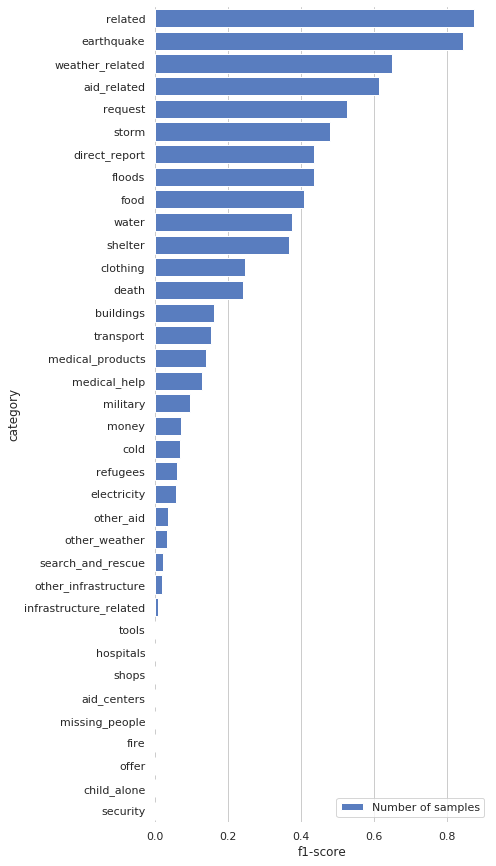

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
 
f, ax = plt.subplots(figsize=(6, 15))
 
sns.set_color_codes("muted")
sns.barplot(x="f1-score", y="category", data=df_metrics.sort_values(by = 'f1-score', ascending = False), label="Number of samples", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)

sns.despine(left=True, bottom=True)

#### Testing with stop words removal

In [31]:
import nltk

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
import re

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_placeholder = '_URL_'

lemmatizer = WordNetLemmatizer()

def create_placeholder_for_urls(text):
    return re.sub(url_regex, url_placeholder, text)

def tokenize(text):
    lower_text = text.lower().strip()
    placeholder_text = create_placeholder_for_urls(lower_text)
    tokens = remove_all_punctuation(placeholder_text) # word_tokenize(placeholder_text)
    only_relevant_words = words_without_stopwords(tokens)
    return list(map(lemmatizer.lemmatize, tokens))

In [33]:
stop_words = stopwords.words('english')

def words_without_stopwords(words):
    return list(filter(lambda w: w not in stop_words, words))

In [34]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10)))
])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [37]:
y_pred = pipeline.predict(X_test)

In [38]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.93      0.87      5007
               request       0.85      0.38      0.52      1123
                 offer       0.00      0.00      0.00        34
           aid_related       0.76      0.52      0.62      2762
          medical_help       0.67      0.07      0.13       530
      medical_products       0.57      0.08      0.15       321
     search_and_rescue       0.64      0.04      0.08       167
              security       0.00      0.00      0.00       124
              military       1.00      0.03      0.06       233
           child_alone       0.00      0.00      0.00         0
                 water       0.89      0.24      0.38       432
                  food       0.86      0.25      0.38       742
               shelter       0.82      0.21      0.33       576
              clothing       0.62      0.08      0.15        97
                 money       0.62      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [12]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ]))
        ])),
    
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, n_estimators = 10))) 
    ])

In [18]:
parameters = {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__text_pipeline__vect__max_features': (None, 5000, 10000),
    #'features__text_pipeline__tfidf__use_idf': (True, False),
    #'features__text_pipeline__tfidf__norm': ('l1', 'l2'),
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__min_samples_split': [2, 3, 4]
}

In [19]:
cv = GridSearchCV(pipeline, param_grid = parameters, n_jobs = -1, verbose = 10)

In [20]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.4min
/home/brunowdev/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 54.4min
[Parallel(n_

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'

In [23]:
cv.best_params_

{'classifier__estimator__min_samples_split': 4,
 'classifier__estimator__n_estimators': 100,
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__max_features': 10000,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [25]:
cv.best_estimator_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [27]:
y_pred = cv.best_estimator_.predict(X_test) 

In [28]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.83      0.97      0.89      5045
               request       0.84      0.51      0.64      1107
                 offer       0.00      0.00      0.00        35
           aid_related       0.78      0.66      0.72      2764
          medical_help       0.64      0.11      0.19       530
      medical_products       0.82      0.19      0.31       319
     search_and_rescue       0.81      0.11      0.19       191
              security       1.00      0.01      0.02       123
              military       0.83      0.08      0.14       196
           child_alone       0.00      0.00      0.00         0
                 water       0.82      0.56      0.67       381
                  food       0.83      0.73      0.78       752
               shelter       0.84      0.47      0.60       568
              clothing       0.91      0.26      0.41       114
                 money       1.00      

/home/brunowdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/brunowdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/brunowdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/brunowdev/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average

#### Testing with translated dataset

In [16]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10)))
])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.94      0.87      5003
               request       0.82      0.37      0.51      1114
                 offer       0.00      0.00      0.00        32
           aid_related       0.73      0.54      0.62      2691
          medical_help       0.61      0.07      0.13       538
      medical_products       0.79      0.07      0.13       331
     search_and_rescue       0.67      0.01      0.02       180
              security       0.00      0.00      0.00       119
              military       0.65      0.06      0.11       212
           child_alone       0.00      0.00      0.00         0
                 water       0.82      0.26      0.40       404
                  food       0.86      0.43      0.57       741
               shelter       0.83      0.26      0.40       596
              clothing       0.71      0.05      0.09       107
                 money       1.00      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [ ]:
{'classifier__estimator__min_samples_split': 4,
 'classifier__estimator__n_estimators': 100,
 'features__text_pipeline__vect__max_df': 0.5,
 'features__text_pipeline__vect__max_features': 10000,
 'features__text_pipeline__vect__ngram_range': (1, 2)
}

In [22]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=tokenize, max_df = 0.5, max_features = 10000, ngram_range = (1, 2))),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators = 100, min_samples_split = 4)))
])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=10000, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tok...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [24]:
y_pred = pipeline.predict(X_test)

In [25]:
print(classification_report(y_test.values, y_pred, target_names=labels, output_dict = False))

                        precision    recall  f1-score   support

               related       0.82      0.97      0.89      5003
               request       0.84      0.49      0.62      1114
                 offer       0.00      0.00      0.00        32
           aid_related       0.76      0.66      0.71      2691
          medical_help       0.62      0.11      0.18       538
      medical_products       0.82      0.20      0.32       331
     search_and_rescue       0.73      0.12      0.21       180
              security       0.00      0.00      0.00       119
              military       0.65      0.06      0.11       212
           child_alone       0.00      0.00      0.00         0
                 water       0.81      0.57      0.67       404
                  food       0.83      0.71      0.76       741
               shelter       0.82      0.49      0.61       596
              clothing       0.81      0.23      0.36       107
                 money       1.00      

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.